#### Overview

Recently I had been working on a project which required that I make a bar chart which changed depending on the value of a dropdown selection.
Before this point I had never really explored this functionality in Plotly save for knowing of its existence and I thought it would be useful to detail my steps because the example provided on their site was not very helpful especially if you are dealing with more than two or three groups.

For this example I am using data collected a while detailing NBA games scores, winners, etc. for each season dating from 1979 to 2017. However, there is a great number of teams in this data set that have moved, changed names or become defunct which increases the likelihood of survivorship bias being present in the plot. While this is not a totally avaoidable phenomenon in this instance I try to minimize it by only including games played after 2009.

Moreover, the ultimate goal for the plot is to show the win percentage a selected team had against each of their opponents between 2010 and 2017.


#### Load Data and Filter

Above we are just loading the data, filtering the dataframe based on the year and creating a unique set of teams included in the subset. 

In [1]:
import pandas as pd
from collections import Counter
from plotly import graph_objs as go

file = "https://cdn.rawgit.com/dtemkin/blog/66b12f0d/data/nba_data.csv"
df = pd.read_csv(file, index_col=0)
subdf = df[df.year>=2010]
teams = set(subdf.away_team)

#### Data Restructuring

Next, the data needs to be restructured so that it plays nice with plotly. For a bar chart we need to be able to specify a set of x and y values for each team. In this instance _X_ will be each of the teams and _Y_ will be the number of games the selected team won. It must be noted that for some other plot types this schema will not work. For example, in plotly, histograms require an array of data points and a counter is constructed internally. 

The losses that each team faces against each opponent is also tracked so that it cant be used in calculating the percantage wins per each opponent.

In [12]:
games = {}
for team in teams:
    games.update({team: {"wins": Counter(), 'losses': Counter()}})
    teamwins = []
    teamlosses = []
    total_games = 0
    for row in subdf.index:
        if subdf.loc[row].away_team == team:
            if subdf.loc[row].winner == 'away':
                teamwins.append(subdf.loc[row].home_team)
            else:
                teamlosses.append(subdf.loc[row].home_team)
        elif subdf.loc[row].home_team == team:
            if subdf.loc[row].winner == 'home':
                teamwins.append(subdf.loc[row].away_team)
            else:
                teamlosses.append(subdf.loc[row].away_team)
        else:
            pass
    games[team]['wins'].update(teamwins)
    games[team]['losses'].update(teamlosses)

    

### Building Figures

When constructing the plot, _fig_ is established as an empty Figure() instance and we create the first button which will correspond to no selection. 

The way plotly handles updates is it creates a different plot for each item only some appear invisible. Then when an name is selected from the dropdown list the button passes new arguments to the figure layout dictating which item should become visible. 

I write this in a loop to prevent a significant amount of hard coding selecting each team individually, and creating a corresponding bar chart. However, before creating the bar chart I ammend the game data for each team to include itself with a count of 0 as well as each team that the selected team didn't play against either because of a rename or move. I add one to the losses so as to prevent a zero division error.

In [16]:
fig = go.Figure()
buttons = [{"label": "Select Team: ", "method": "update", "args": [{'visible': [False for tm in teams]}]}]
for tm in teams:
    wins_dict = dict(games[tm]['wins'])
    losses_dict = dict(games[tm]['losses'])
    wins_dict.update({tm: 0})
    wins_dict.update({tx: 0 for tx in teams if tx not in wins_dict})
    
    losses_dict.update({tm: 1})
    losses_dict.update({tx: 1 for tx in teams if tx not in losses_dict})
    
    
    tot_games = {t: wins_dict[t]+losses_dict[t] for t in teams}
    pct_wins = {t: round(wins_dict[t]/tot_games[t], 4) for t in teams}
    
    
    trace = go.Bar(x=list(pct_wins.keys()), y=list(pct_wins.values()),
                   name=tm + " wins", visible=False, hoverinfo="text", 
                   hovertext=[f"Wins: {wins_dict[tm1]}\nTotal:{tot_games[tm1]}" 
                              for tm1 in teams])
    
    btnx = {"label": tm, 'method': 'update',
            "args": [{'visible': [True if tm == tmx else False for tmx in teams]}]}
    fig.add_trace(trace)
    
    buttons.append(btnx)

### Finalizing Plot

Finally, the figure layout is updated to include the menu buttons, title and size parameters.

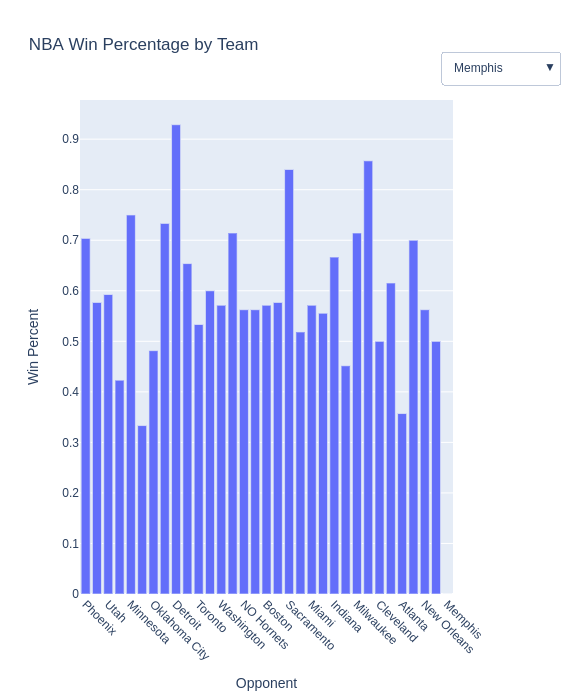

In [20]:
fig.update_layout(
    {"updatemenus":[
        go.layout.Updatemenu(buttons=buttons, direction="down",
                             pad={"r": 5, "t": 0}, showactive=True,
                             xanchor="right", x=1.3, yanchor="top", y=1.10)],
        'title_text': 'NBA Win Percentage by Team',
        'xaxis': dict(title='Opponent', tickangle=45),
        'yaxis_title_text': 'Win Percent',
        "width": 900, "height": 700,
        "autosize": True})
fig.show()


#### Conclusion

Ultimately, I hope this helps anyone who has been struggling as much as I did. One thing I found especially noteworthy when constructing this graph is that I could not find a way to bind more than one plot to the dropdown list successfully. Whenever I tried to created a second plot and I selected an item in the dropdown list the pair of plots that showed up seemed to be selected at random. I found the issue in the plotly code on github and it seems that whenever multiple plots are added using add_traces() they _extend_ the list of plots rather than _append_ to it. According to the code comments this is to prevent serialization when converting the code to JS. I have submitted an issue highlighting this problem but in the meantime it will be necessary to construct plots independently when using a menu selection.

I have posted the code for this project [here]() in case you are interested. 